In [ ]:
import openreview
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
from scipy.stats import norm
from collections import Counter
import collections
import itertools
from math import comb
import json
from datetime import datetime

In [15]:
"""
Load the data
"""
def extract_number(string):
    colon_index = string.find(":")
    if colon_index != -1:
        number_str = string[:colon_index].strip()
        if number_str.isdigit():
            return int(number_str)

client = openreview.Client(baseurl='https://api.openreview.net')

    
submissions = client.get_all_notes(
    invitation="ICLR.cc/2023/Conference/-/Blind_Submission",
    details='directReplies'
)

papers = [] 
for submission in submissions:
    authorids = submission.content['authorids']
    scores = []
    for reply in submission.details["directReplies"]:
        print(reply)
        if reply["invitation"].endswith("Decision"):
            forum = reply['forum']
            decision = reply['content']['decision']
        if reply["invitation"].endswith("Official_Review"):
            score = extract_number(reply['content']['rating'])
            scores += [score]
        if reply['id'] == 'MXV1TACjo_':
            print()
    review = {'forum': forum, 'authorids': authorids, 'decision': decision, 'scores': scores}
    papers.append(review)
    
    
    
# with open('papers_2021.json', 'r') as file:
#     papers = json.load(file)
# papers[0]

Getting V1 Notes: 100%|███████████████████▉| 3802/3806 [00:05<00:00, 659.64it/s]

{'id': 'MXV1TACjo_', 'original': None, 'number': 1, 'cdate': 1666251648361, 'mdate': None, 'ddate': None, 'tcdate': 1666251648361, 'tmdate': 1669196188530, 'tddate': None, 'forum': 'zzqBoIFOQ1', 'replyto': 'zzqBoIFOQ1', 'invitation': 'ICLR.cc/2023/Conference/Paper3283/-/Official_Review', 'content': {'confidence': '4: You are confident in your assessment, but not absolutely certain. It is unlikely, but not impossible, that you did not understand some parts of the submission or that you are unfamiliar with some pieces of related work.', 'summary_of_the_paper': 'This paper deals with safe exploration in reinforcement learning in which an agent is required to ensure safety during training. The authors present a neuro-symbolic approach called SPICE. based on symbolic weakest preconditions. Empirically, they evaluate their approach on toy benchmarks, and show that it is able to achieve comparable performance to existing safe learning techniques while incurring fewer safety violations. ', 'st

KeyError: 'rating'

In [87]:
"""
Some tool functions
"""

def count_scores_by_length(lst, k):
    counts = {}
    for item in lst:
        scores = item.get('scores', [])
        if len(scores) == k:
            counts[k] = counts.get(k, 0) + 1
    return counts

def count_keys_with_value(dictionary, v):
    count = 0
    for value in dictionary.values():
        if value == v:
            count += 1
    return count

def get_keys_with_value(dictionary, v):
    keys_with_value = []
    for key, value in dictionary.items():
        if value == v:
            keys_with_value.append(key)
    return keys_with_value

count_scores_by_length(papers, 3)

{3: 520}

mean score = 5.51073217726397 
std of score = 1.0093838772209565


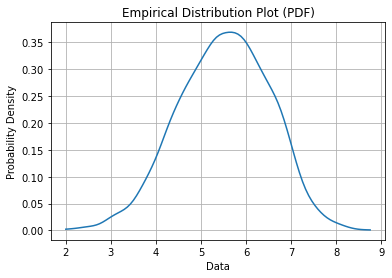

In [90]:
# learn the prior of paper quality. See Appendix C for the detials of the model

n = len(papers)
score_list_avg = np.zeros(n)
for i in range(n):
    score_list_avg[i] = np.average(papers[i]['scores'])
    
mu_q = np.average(score_list_avg)
sig_q = np.std(score_list_avg)
print('mean score =', mu_q, '\nstd of score =', sig_q)

def plot_empirical_distribution(data):
    # Estimate the probability density function (PDF)
    kde = gaussian_kde(data)

    # Generate a range of values for x-axis
    x = np.linspace(min(data), max(data), 100)

    # Evaluate the PDF at the given x values
    pdf = kde.evaluate(x)

    # Plot the empirical distribution
    plt.plot(x, pdf)
    plt.xlabel('Data')
    plt.ylabel('Probability Density')
    plt.title('Empirical Distribution Plot (PDF)')
    plt.grid(True)
    plt.show()
    
plot_empirical_distribution(score_list_avg)

Fitted t: -0.5132958798315422


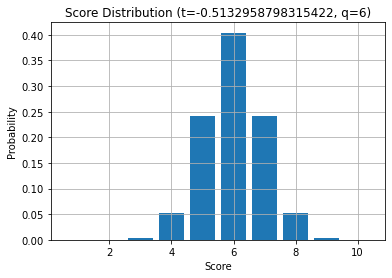

In [89]:
# learn the review noise

def fit_parameter_t(data):
    # Define the log-likelihood function
    def log_likelihood(t):
        log_likelihood_val = 0

        for entry in data:
            scores = np.array(entry)
            q = np.mean(scores)
            log_denominator = np.log(np.sum(np.exp(t * (np.arange(1, 11) - q)**2)))
            log_likelihood_val += np.sum(t * (scores - q)**2 - log_denominator)

        return -log_likelihood_val

    # Initial guess for parameter t
    initial_t = 1.0

    # Minimize the negative log-likelihood to estimate t
    result = minimize(log_likelihood, initial_t, method='BFGS')

    fitted_t = result.x[0]
    return fitted_t

n = len(papers)
score_list = []
for i in range(n):
    score_list.append(papers[i]['scores'])

t = fit_parameter_t(score_list)
print("Fitted t:", t)

def plot_score_distribution(t, q):
    scores = np.arange(1, 11)
    probabilities = np.exp(t * (scores - q)**2) / np.sum(np.exp(t * (scores - q)**2))

    plt.bar(scores, probabilities)
    plt.xlabel('Score')
    plt.ylabel('Probability')
    plt.title('Score Distribution (t={}, q={})'.format(t, q))
    plt.grid(True)
    plt.show()
    
plot_score_distribution(t, 6)

In [91]:
# learn the prior of number of papers each author has
# Assign papers to the author with the most papers

def find_most_common_string(dictionary):
    string_counts = {}

    for values in dictionary.values():
        for string in values:
            string_counts[string] = string_counts.get(string, 0) + 1

    most_common_string = max(string_counts, key=string_counts.get)
    return most_common_string, string_counts[most_common_string]


def assign_authors_to_papers(paper_dict):
    assigned_papers = {}
    
    while paper_dict:
        author_max, count = find_most_common_string(paper_dict)
        if count == 1:
            for key, values in paper_dict.items():
                assigned_papers[key] = values[0]
            return assigned_papers

        papers_to_remove = []
        for key, values in paper_dict.items():
            if any(author_max in value for value in values):
                papers_to_remove.append(key)
                assigned_papers[key] = author_max

        for paper in papers_to_remove:
            del paper_dict[paper]


paper_author_map = {}
n = len(papers)
score_list = []
for i in range(n):
    paper_author_map[papers[i]['forum']] = papers[i]['authorids']

assigned_papers = assign_authors_to_papers(paper_author_map)

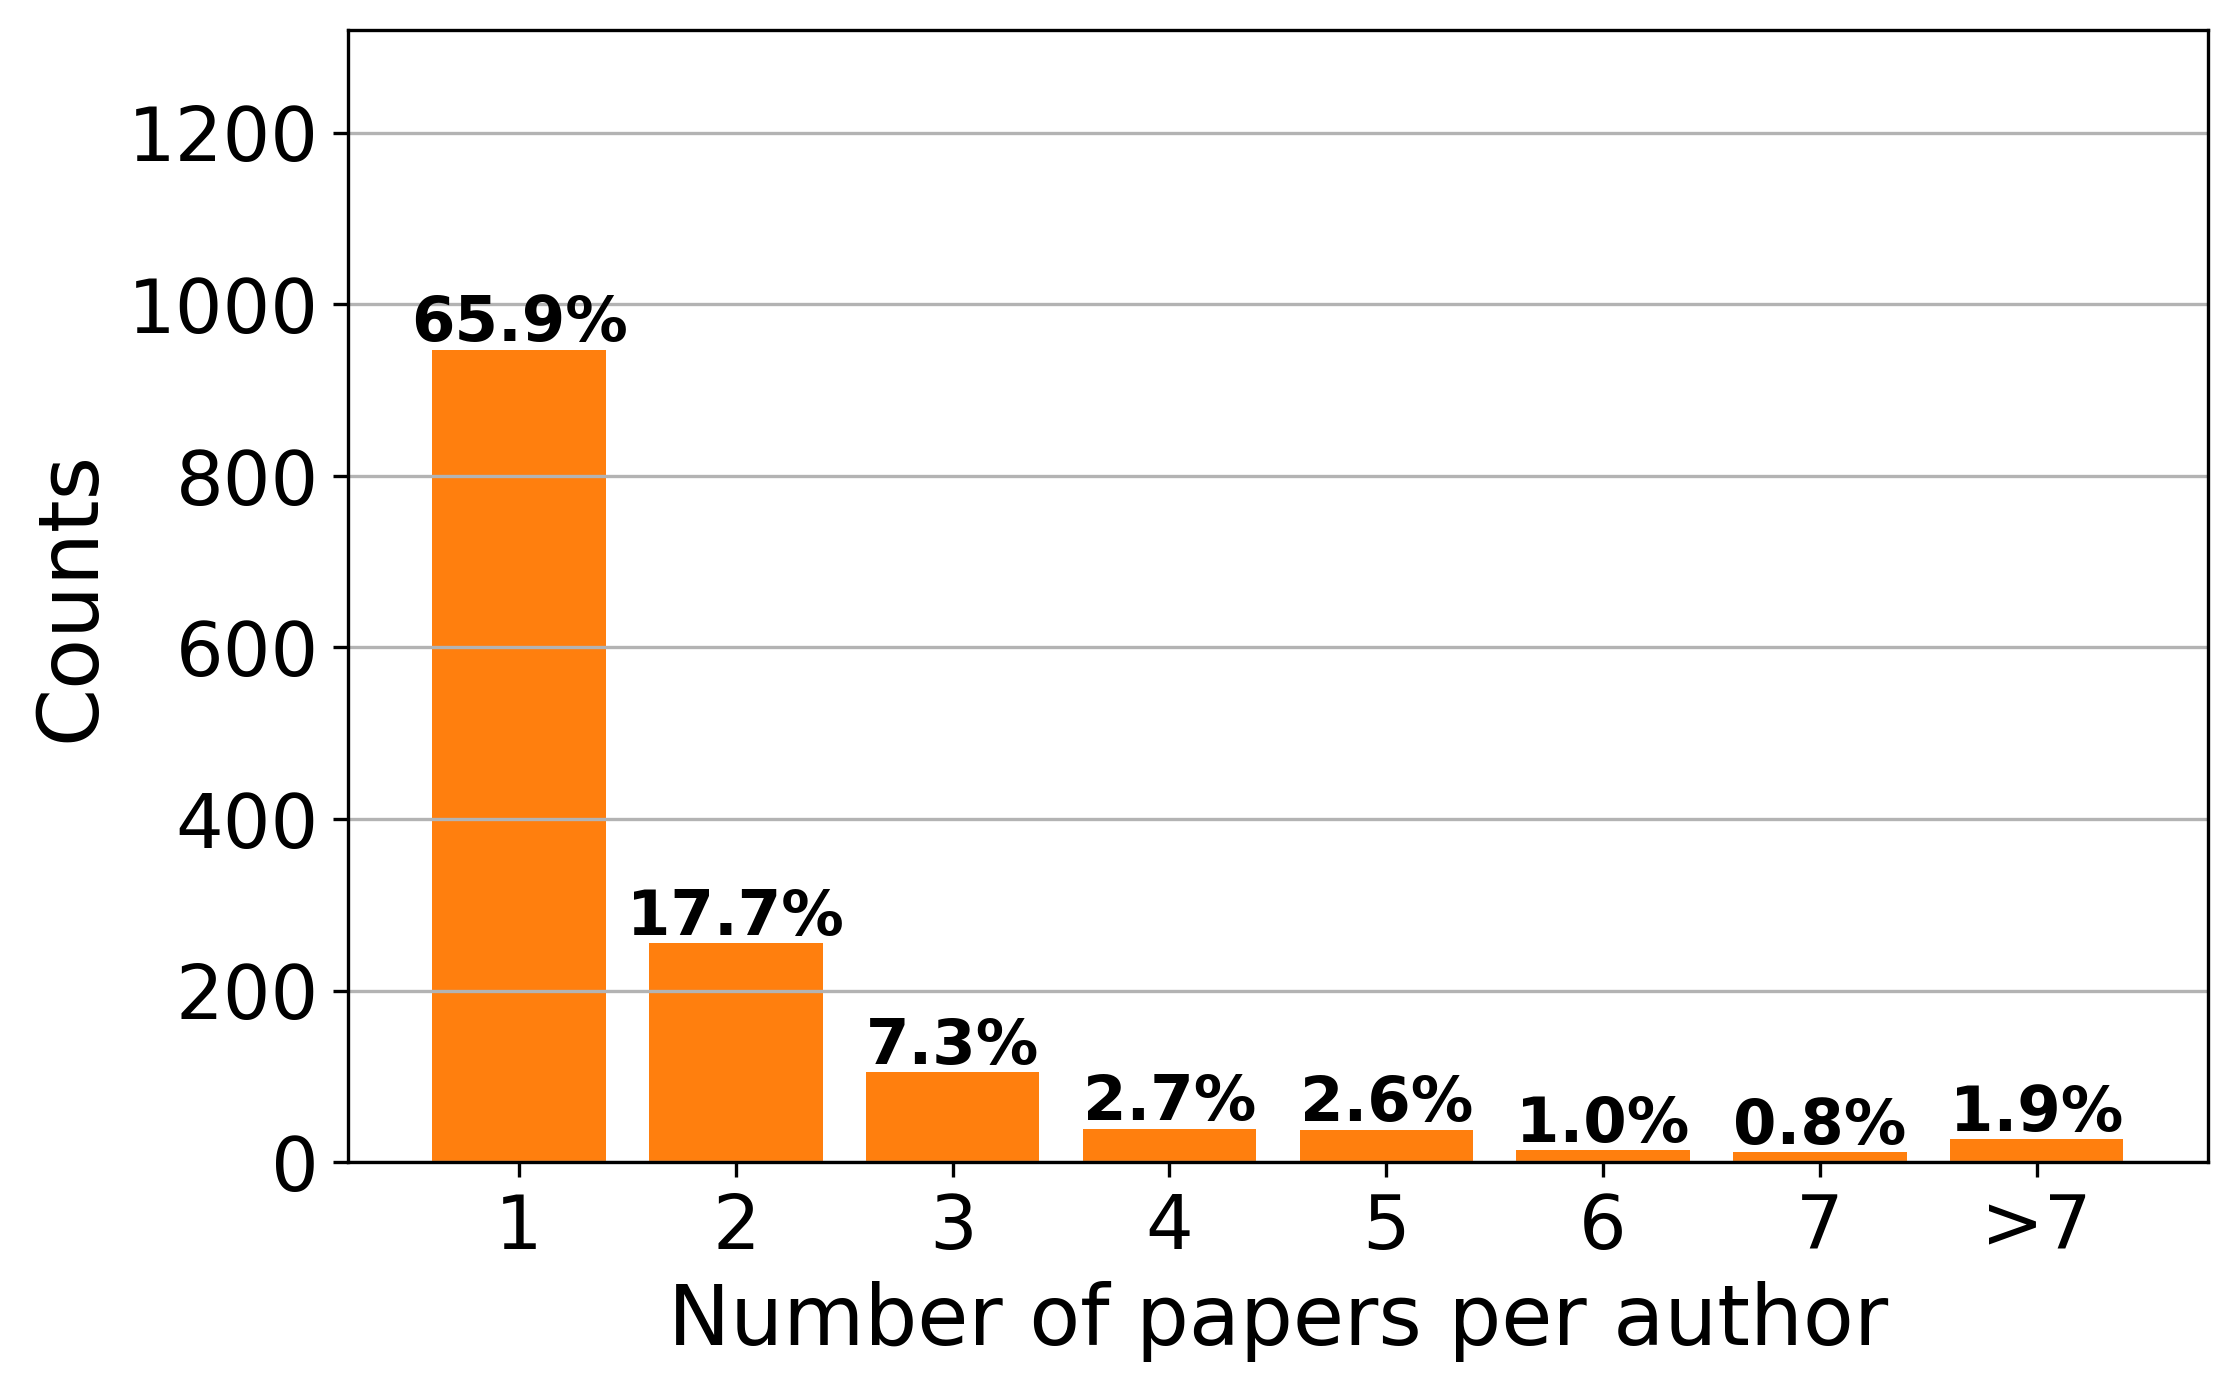

In [94]:
"Visualize the distirbution of the number of papers each author has"

def plot_author_paper_distribution(paper_dict):
    author_paper_counts = {}

    # Count the number of papers for each author
    for author in paper_dict.values():
        author_paper_counts[author] = author_paper_counts.get(author, 0) + 1

    # Count the number of authors for each number of papers
    paper_counts = {}
    for count in author_paper_counts.values():
        if count <= 7:
            paper_counts[str(count)] = paper_counts.get(str(count), 0) + 1
        else:
            paper_counts['>7'] = paper_counts.get('>7', 0) + 1

    # Create the plot
    x = list(paper_counts.keys())[::-1]
    y = list(paper_counts.values())[::-1]

    fig, ax = plt.subplots(dpi = 300)
    plt.rcParams['figure.figsize'] = (8, 5)
    
    bars = ax.bar(
    x=x,
    height = y
    )
    
    plt.bar(x, y)
    plt.xlabel("Number of papers per author", fontsize = '20')
    plt.ylabel("Counts", fontsize = '20')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    ax.yaxis.grid(True, color='#B3B3B3')
    ax.xaxis.grid(False)
    plt.ylim(0,1320)
    
    for i,bar in enumerate(bars):
        ax.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + 10,
          str(np.round(y[i]/sum(y)*100, 1))+'%',
            fontsize = 15,
          horizontalalignment='center',
          color='black',
          weight='bold'
          )
    
def calculate_author_paper_distribution(paper_dict):
    author_paper_counts = {}

    # Count the number of papers for each author
    for author in paper_dict.values():
        author_paper_counts[author] = author_paper_counts.get(author, 0) + 1

    # Count the number of authors for each number of papers
    paper_counts = {}
    for count in author_paper_counts.values():
        paper_counts[count] = paper_counts.get(count, 0) + 1

    tmp = np.array(sorted(paper_counts.items()))
    N = np.sum(tmp[:, 1])
    frequency = tmp[:, 1] / N
    output = np.column_stack((tmp, frequency))
    output[:,:2] = output[:,:2].astype(int)
    return output

number_of_paper_frequency = calculate_author_paper_distribution(assigned_papers)
plot_author_paper_distribution(assigned_papers)
# print(number_of_paper_frequency, np.sum(number_of_paper_frequency[:,0]*number_of_paper_frequency[:,2]))

## The Softmax Review Model and the Mechanisms

In [96]:
"""
Define the model
"""

class RealConfParams:
    def __init__(self, n, k, mu_q, sig_q, t):
        self.n = n            # number of papers
        self.k = k            # number of reviews
        self.mu_q = mu_q      # mean of quality prior
        self.sig_q = sig_q    # std of quality prior
        self.t = t            # temperature of review noise
        
        
# draw samples from quality distribution
def sample_q(para, nmc):
    samples = np.random.normal(loc=para.mu_q, scale=para.sig_q, size=(nmc,para.n))
    return np.sort(samples, axis = 1, kind='quicksort')[:,::-1]

n = 20
k = 3

para = RealConfParams(
        n = n,
        k = k,
        mu_q = mu_q,
        sig_q = sig_q,
        t = t
        )

q_samples = sample_q(para, 1000)

In [97]:
"""
Compute possible thresholds
"""

def MAP_estimator_q(para, signals):
    t = para.t
    mu_q = para.mu_q
    sig_q = para.sig_q
    
    def log_MAP(q):
        log_prior = np.log(norm.pdf(q,mu_q, sig_q))
        sigs = np.array(signals)
        log_MAP_val = np.sum(t * (sigs - q)**2)+ log_prior

        return -log_MAP_val
    
    initial_q = 5

    # Minimize the negative log-likelihood to estimate t
    result = minimize(log_MAP, initial_q, method='BFGS')
    fitted_q = result.x[0]
    return fitted_q

global possible_thresholds
possible_thresholds = {}
for combination in itertools.combinations_with_replacement(range(1, 11), k):
    sorted_combination = tuple(sorted(combination))
    possible_thresholds[sorted_combination] = MAP_estimator_q(para, combination)
possible_thresholds = dict(sorted(possible_thresholds.items(), key = lambda item: item[1]))

In [98]:
def acceptance_probability(para, q, t_acc):
    t = para.t
    k = para.k
    nmc = np.size(q, axis = 0)
    acc_probability = np.zeros(nmc)
    
    scores = np.arange(1, 11)
    q_reshape = q[np.newaxis, :]
    
    for combination in itertools.product(range(1, 11), repeat=k):
        sorted_combination = tuple(sorted(combination))
        estimated_q = possible_thresholds[sorted_combination]
        if estimated_q >= t_acc:
            prob = np.exp(t*(np.array(combination)[:, np.newaxis] - q_reshape)**2) / np.sum(np.exp(t*(scores[:, np.newaxis] - q_reshape)**2), axis = 0)
            acc_probability += np.prod(prob, axis = 0)
            
    return acc_probability

def parallel_quality_discrete(para, q, t_acc):
    nmc = np.size(q, axis = 0)
    n = para.n
    t = para.t
    
    q_acc = np.zeros(nmc)
    for i in range(n):
        p_acc = acceptance_probability(para, q[:,i], t_acc)
        q_acc += p_acc*(q[:,i] - 5.5)
    return (np.average(q_acc), np.var(q_acc))

parallel_quality_discrete(para, q_samples, 5.6)

(7.040046651779769, 7.269577134732981)

In [99]:
def sequential_quality_discrete(para, q, t_acc, t_rev):
    t = para.t
    k = para.k
    n = para.n
    nmc = np.size(q, axis = 0)
    acc_probability = np.zeros(nmc)
    
    q_acc = np.zeros(nmc)
    q_rev = np.zeros(nmc)
    p_rev = np.ones(nmc)
    n_rev = np.zeros(nmc)
    for i in range(n):
        p_acc = acceptance_probability(para, q[:,i], t_acc)
        q_acc += p_acc*p_rev*(q[:,i] - 5.5)
        q_rev += p_rev*q[:,i]
        n_rev += p_rev
        p_rev *= acceptance_probability(para, q[:,i], t_rev)
    
    return (np.average(q_acc), np.average(n_rev))

sequential_quality_discrete(para, q_samples, 5.3, 5.3)

(7.506546539698358, 10.055410109547347)

In [ ]:
"""
This part is used to compute the optimal conference quality and reiview burden under different accetpance threshold.
Based on our observation that the optimal t_rev is usually equal to t_acc, we simply set t_rev = t_acc to save time in this experiment.
This takes hours to run, can skip.
"""

utility_parallel = []
utility_sequential = []
n_review_parallel = []
n_review_sequential = []

for i,t_acc in enumerate(possible_thresholds.values()):
    print(i+1, "of 120,", datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    u_p = 0
    u_s = 0
    n_p = 0
    n_s = 0
    for item in number_of_paper_frequency:
        n = int(item[0])
        n_paper = int(item[1])
        freq = item[2]
        para = RealConfParams(
                n = n,
                k = k,
                mu_q = mu_q,
                sig_q = sig_q,
                t = t
                )
        q_samples = sample_q(para, 10000)
        u_p += parallel_quality_discrete(para, q_samples, t_acc)[0]*freq
        output_s = sequential_quality_discrete(para, q_samples, t_acc, t_acc)
        u_s += output_s[0]*freq
        n_p += n*n_paper
        n_s += output_s[1]*n_paper
    utility_parallel.append(u_p)
    utility_sequential.append(u_s)
    n_review_parallel.append(n_p)
    n_review_sequential.append(n_s)
    
# np.save('Numerical_results/Real_data/utility_parallel_2020.npy', utility_parallel)
# np.save('Numerical_results/Real_data/utility_sequential_2020.npy', utility_sequential)
# np.save('Numerical_results/Real_data/n_review_parallel_2020.npy', n_review_parallel)
# np.save('Numerical_results/Real_data/n_review_sequential_2020.npy', n_review_sequential)

[0.8056655345421495]
[0.8056655345421495, 0.8068192976306209]
[0.8056655345421495, 0.8068192976306209, 0.7724694995075947]


(0.6, 1.0)

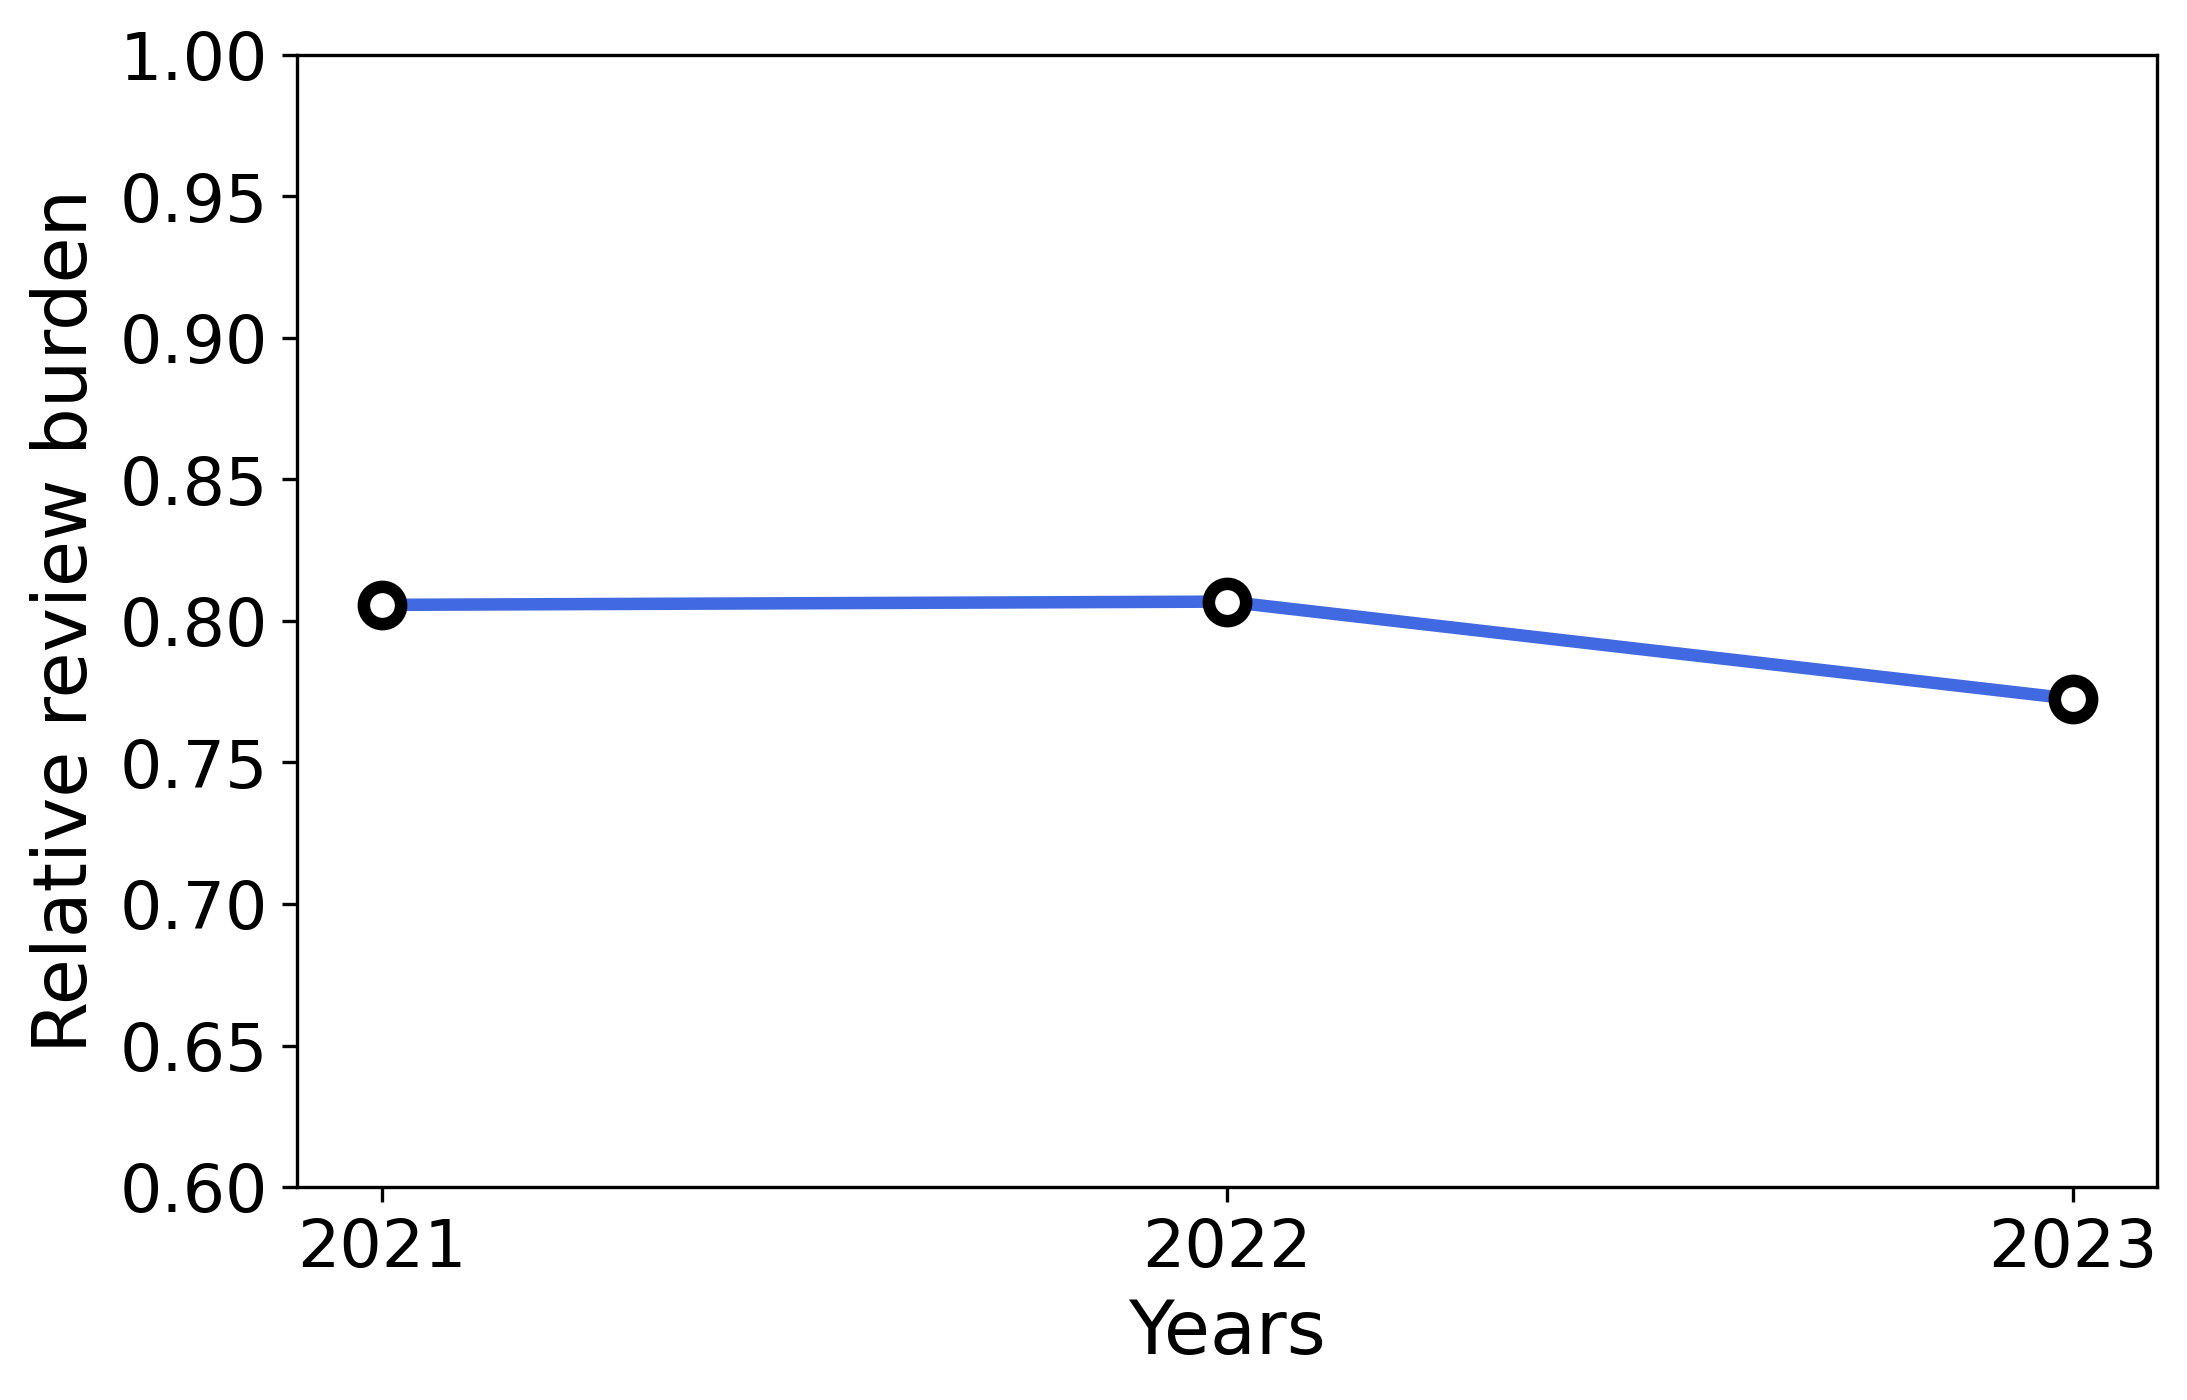

In [532]:
"""
Visualizing the relative review burden on real-data simulated model. See section 5.3.
"""

u_gain = []
r_reduce = []
for year in ['2021', '2022', '2023']:
    utility_parallel = np.load('Numerical_results/Real_data/utility_parallel_'+year+'.npy')
    utility_sequential = np.load('Numerical_results/Real_data/utility_sequential_'+year+'.npy')
    n_review_parallel = np.load('Numerical_results/Real_data/n_review_parallel_'+year+'.npy')
    n_review_sequential = np.load('Numerical_results/Real_data/n_review_sequential_'+year+'.npy')

    index = np.where(np.array(utility_sequential) >= np.max(utility_parallel))
    u_gain.append((np.max(utility_sequential) - np.max(utility_parallel))/np.max(utility_parallel))
    r_reduce.append(np.min(np.array(n_review_sequential)[index])/np.max(n_review_parallel))
    print(r_reduce)

fig, ax = plt.subplots(dpi = 300)
plt.rcParams['figure.figsize'] = (8, 5)
plt.scatter(['2021', '2022', '2023'], r_reduce, s = 80, edgecolor='black', linewidths=3, color = 'white')
plt.plot(['2021', '2022', '2023'], r_reduce, linewidth = 3, color = 'royalblue', zorder = 0)
plt.xlabel("Years", fontsize = '18')
plt.ylabel("Relative review burden", fontsize = '18')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# ax.yaxis.grid(True, color='#B3B3B3')
# ax.xaxis.grid(False)
plt.ylim(0.6,1)